<a href="https://colab.research.google.com/github/Vaggelis-Arg/Amazon-Ecommerce-Analysis/blob/main/Amazon_Ecommerce_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining (2024-2025)

### Team Information

#### Team member #1: [**Vaggelis-Arg**](https://github.com/Vaggelis-Arg)
* Name: Evangelos Argyropoulos
* ID: sdi2200010
* Email: sdi2200010@di.uoa.gr
---
#### Team member #2: [**chrisvl11**](https://github.com/chrisvl11)
* Name: Christos Vladikas
* ID: sdi2200020
* Email: sdi2200020@di.uoa.gr
---
#### Team member #3: [**tonykalantzis**](https://github.com/tonykalantzis)
* Name: Antonios Panagiotis Kalatzis
* ID: sdi2100046
* Email: sdi2100046@di.uoa.gr
---

## Set up of the notebook

### Downloads

In [39]:
!pip install nltk
!pip install datasets
!pip install contractions
!pip install matplotlib seaborn wordcloud
!pip install transformers

### Imports

In [40]:
import nltk
nltk.download(['punkt', 'stopwords', 'vader_lexicon', 'wordnet'])
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset
import pandas as pd
import re
import string
import contractions
from datasets import load_dataset
from matplotlib.gridspec import GridSpec


[nltk_data] Downloading package punkt to
[nltk_data]     /home/vaggelisarg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vaggelisarg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/vaggelisarg/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/vaggelisarg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Part 1 - Pre-processing

### Task 1: Data Exploration and Feature Engineering

#### Dataset Preparation

We used the `datasets` library from Hugging Face to stream and extract reviews and metadata for selected Amazon product categories. For demonstration, we focused on the "All_Beauty" category.

The dataset includes product reviews, ratings, and associated metadata. After loading, the data was saved as CSV files (`*_reviews_raw.csv` and `*_metadata_raw.csv`) to simplify further processing.

We ensure the CSVs contain essential fields like `rating`, `text`, `parent_asin`, and product details for later analysis.



In [42]:
# Configs: (category_name, review_config, meta_config)
datasets_info = [
    ("Books", "raw_review_Books", "raw_meta_Books"),
    ("All_Beauty", "raw_review_All_Beauty", "raw_meta_All_Beauty"),
    ("Electronics", "raw_review_Electronics", "raw_meta_Electronics"),
    ("Movies_and_TV", "raw_review_Movies_and_TV", "raw_meta_Movies_and_TV"),
    ("Sports_and_Outdoors", "raw_review_Sports_and_Outdoors", "raw_meta_Sports_and_Outdoors"),
]
    
# Select correct columns 
review_columns = [
    "rating", "title", "text", "parent_asin", "user_id", "timestamp", 
    "helpful_vote", "verified_purchase"
]
meta_columns = [
    "parent_asin", "main_category", "title", "average_rating", "rating_number",
    "description", "price", "categories", "bought_together", "store"
]

for category, review_config, metadata_config in datasets_info:
    print(f"Loading: {category}")

    # Load streaming datasets with limited columns
    reviews_iter = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        review_config,
        split="full",
        streaming=True,
        trust_remote_code=True
    ).select_columns(review_columns)

    metadata_iter = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        metadata_config,
        split="full",
        streaming=True,
        trust_remote_code=True
    ).select_columns(meta_columns)

    # Convert to pandas and save
    reviews_df = pd.DataFrame(reviews_iter.take(200_000))
    metadata_df = pd.DataFrame(metadata_iter.take(200_000))

    reviews_df.to_csv(f"{category}_reviews_selected.csv", index=False)
    metadata_df.to_csv(f"{category}_metadata_selected.csv", index=False)

    print(f"Saved selected columns for {category}")
    

Loading: Books
Saved selected columns for Books
Loading: All_Beauty
Saved selected columns for All_Beauty
Loading: Electronics
Saved selected columns for Electronics
Loading: Movies_and_TV
Saved selected columns for Movies_and_TV
Loading: Sports_and_Outdoors
Saved selected columns for Sports_and_Outdoors


#### Text Preprocessing

Text fields like `title` and `review text` were cleaned using a custom preprocessing function that includes:

- Lowercasing
- URL, mention, hashtag, and email removal
- Contraction expansion (`don't` → `do not`)
- Emoticon normalization (e.g., `:)` → `happy`)
- Removal of punctuation, numbers, and excessive character repetitions

These cleaned fields (`cleaned_title`, `cleaned_text`) are used for visualizations and later analysis tasks.


In [44]:
# Emoticon dictionary for replacements
emoticons = {
    ":)": "happy",
    ":-)": "happy",
    ":(": "sad",
    ":-(": "sad",
    ":D": "happy",
    ":-D": "happy",
    ";)": "wink",
    ";-)": "wink"
}

def normalize_price(price, min_price, max_price):
    return (price - min_price) / (max_price - min_price) if max_price != min_price else 0

# Preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r"\@\w+|\#\w+", '', text)  # remove mentions and hashtags
    text = re.sub(r"\S+@\S+", '', text)  # remove emails
    text = contractions.fix(text)  # expand contractions

    # Replace emoticons
    for emoticon, word in emoticons.items():
        text = text.replace(emoticon, word)

    text = re.sub(r"[" + string.punctuation + "]", '', text)  # remove punctuation
    text = re.sub(r"\d+", '', text)  # remove numbers
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)  # reduce 3+ char repeats to 2

    text = text.strip()
    return text

# Load and clean each dataset
for category, *_ in datasets_info:
    print(f"Processing: {category}")
    reviews = pd.read_csv(f"{category}_reviews_selected.csv")
    metadata = pd.read_csv(f"{category}_metadata_selected.csv")

    reviews = reviews.dropna(subset=["rating", "text", "parent_asin"])
    reviews["cleaned_title"] = reviews["title"].apply(preprocess_text)
    reviews["cleaned_text"] = reviews["text"].apply(preprocess_text)
    reviews["timestamp"] = pd.to_datetime(reviews["timestamp"], unit="ms")

    df = pd.merge(reviews, metadata, on="parent_asin", how="left", suffixes=("", "_meta"))
    
    if 'price' in df.columns:
        df['price'] = pd.to_numeric(df['price'], errors='coerce')
        
        # Remove any rows where price is NaN
        df = df.dropna(subset=['price'])
        
        min_price = df['price'].min()
        max_price = df['price'].max()
        df['normalized_price'] = df['price'].apply(lambda x: normalize_price(x, min_price, max_price))
        
    df.to_csv(f"{category}_cleaned.csv", index=False)
    print(f"Saved cleaned data to {category}_cleaned.csv")

print(reviews.head())

Processing: Books


/tmp/ipykernel_5430/3389777679.py:42: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{category}_metadata_selected.csv")


Saved cleaned data to Books_cleaned.csv
Processing: All_Beauty
Saved cleaned data to All_Beauty_cleaned.csv
Processing: Electronics


/tmp/ipykernel_5430/3389777679.py:42: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{category}_metadata_selected.csv")


Saved cleaned data to Electronics_cleaned.csv
Processing: Movies_and_TV


/tmp/ipykernel_5430/3389777679.py:42: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{category}_metadata_selected.csv")


Saved cleaned data to Movies_and_TV_cleaned.csv
Processing: Sports_and_Outdoors


/tmp/ipykernel_5430/3389777679.py:42: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{category}_metadata_selected.csv")


Saved cleaned data to Sports_and_Outdoors_cleaned.csv
   rating               title  \
0     5.0        Crazy comfy!   
1     5.0          Excellent!   
2     5.0    Best saddle pads   
3     5.0  Perfect repair kit   
4     5.0         Works great   

                                                text parent_asin  \
0  Not gonna lie- they are not much to look at. L...  B0BGFR76CF   
1                                 I love it. Pretty!  B00NXQLFQQ   
2  Huge fan of B Vertigo and this dressage pad do...  B0957WLR63   
3  I have a great Weaver halter. Recently, the Ch...  B00IET8S80   
4  This was great for a slightly too-short girth!...  B01C2SW7XA   

                        user_id               timestamp  helpful_vote  \
0  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2023-02-25 10:30:53.520             8   
1  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2018-04-07 09:36:11.676             0   
2  AGGZ357AO26RQZVRLGU4D4N52DZQ 2022-05-26 01:01:59.105             0   
3  AGGZ357AO26RQZVRLGU4D4N52DZQ 2021-07-26 20:

#### Review Ratings and Trends

We performed exploratory data analysis on the cleaned dataset, including:

- **Rating distribution** histograms to understand the spread of reviews across 1–5 stars.
- **Word cloud visualizations** for low-rated yet popular products, highlighting commonly used words in negative reviews.
- **Top 5 best-selling products** based on review count, with metadata summaries printed for each.
- **Monthly rating trends** using line plots to observe how customer sentiment evolved over time.

These visual insights help identify patterns, seasonality, and quality issues across products.


Visualizing: Books


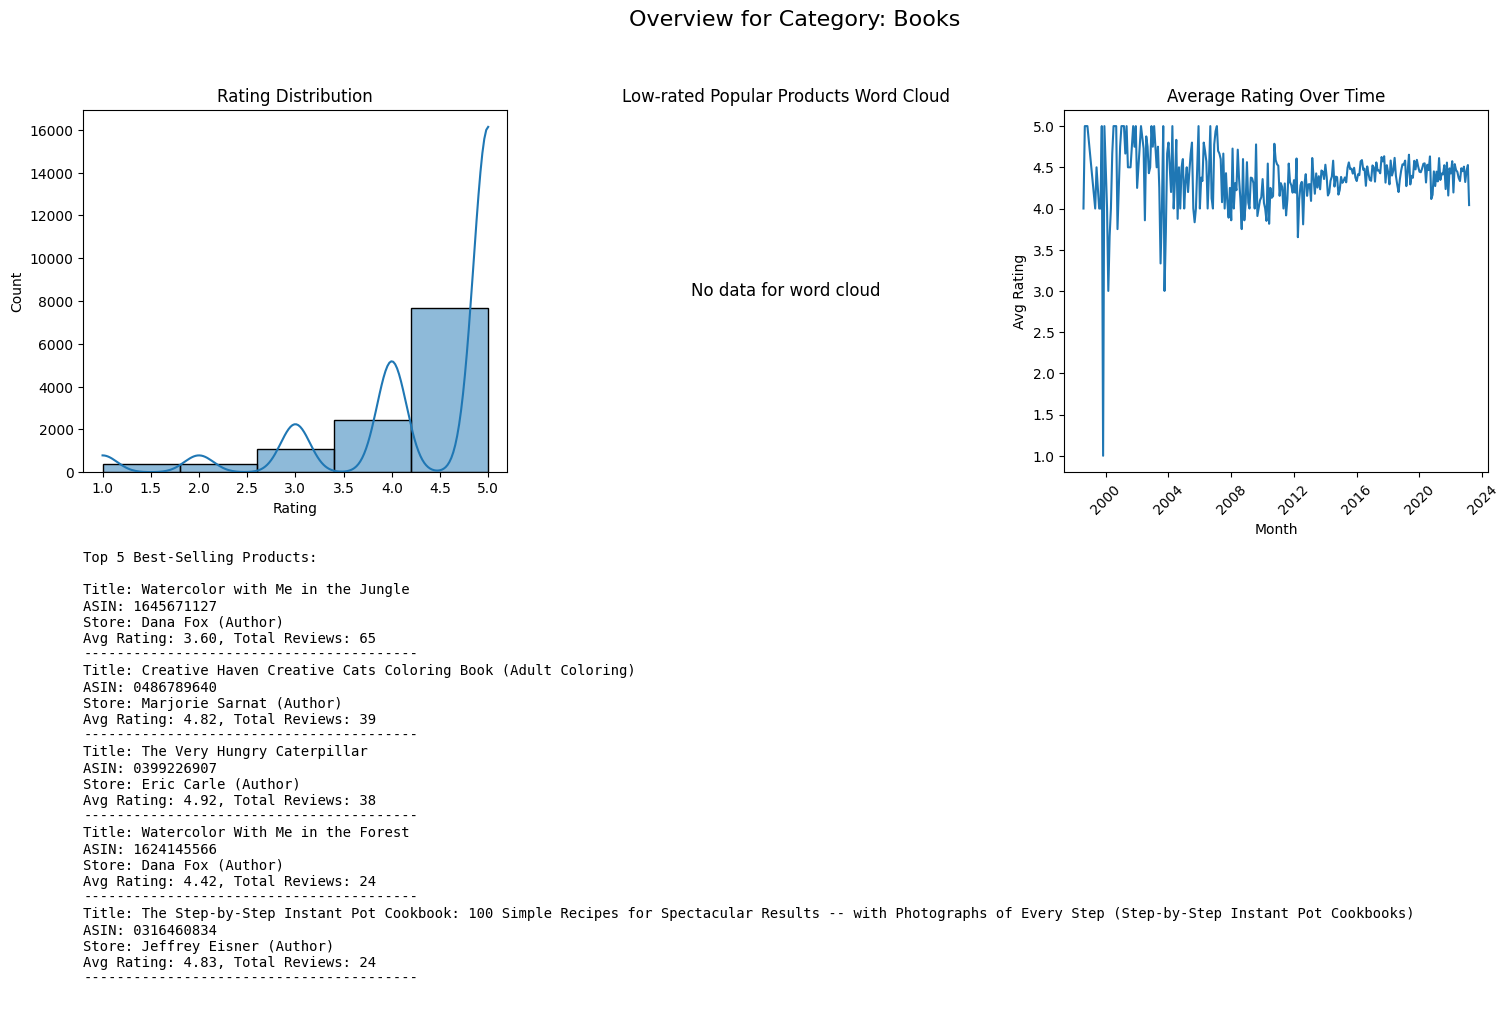

Visualizing: All_Beauty


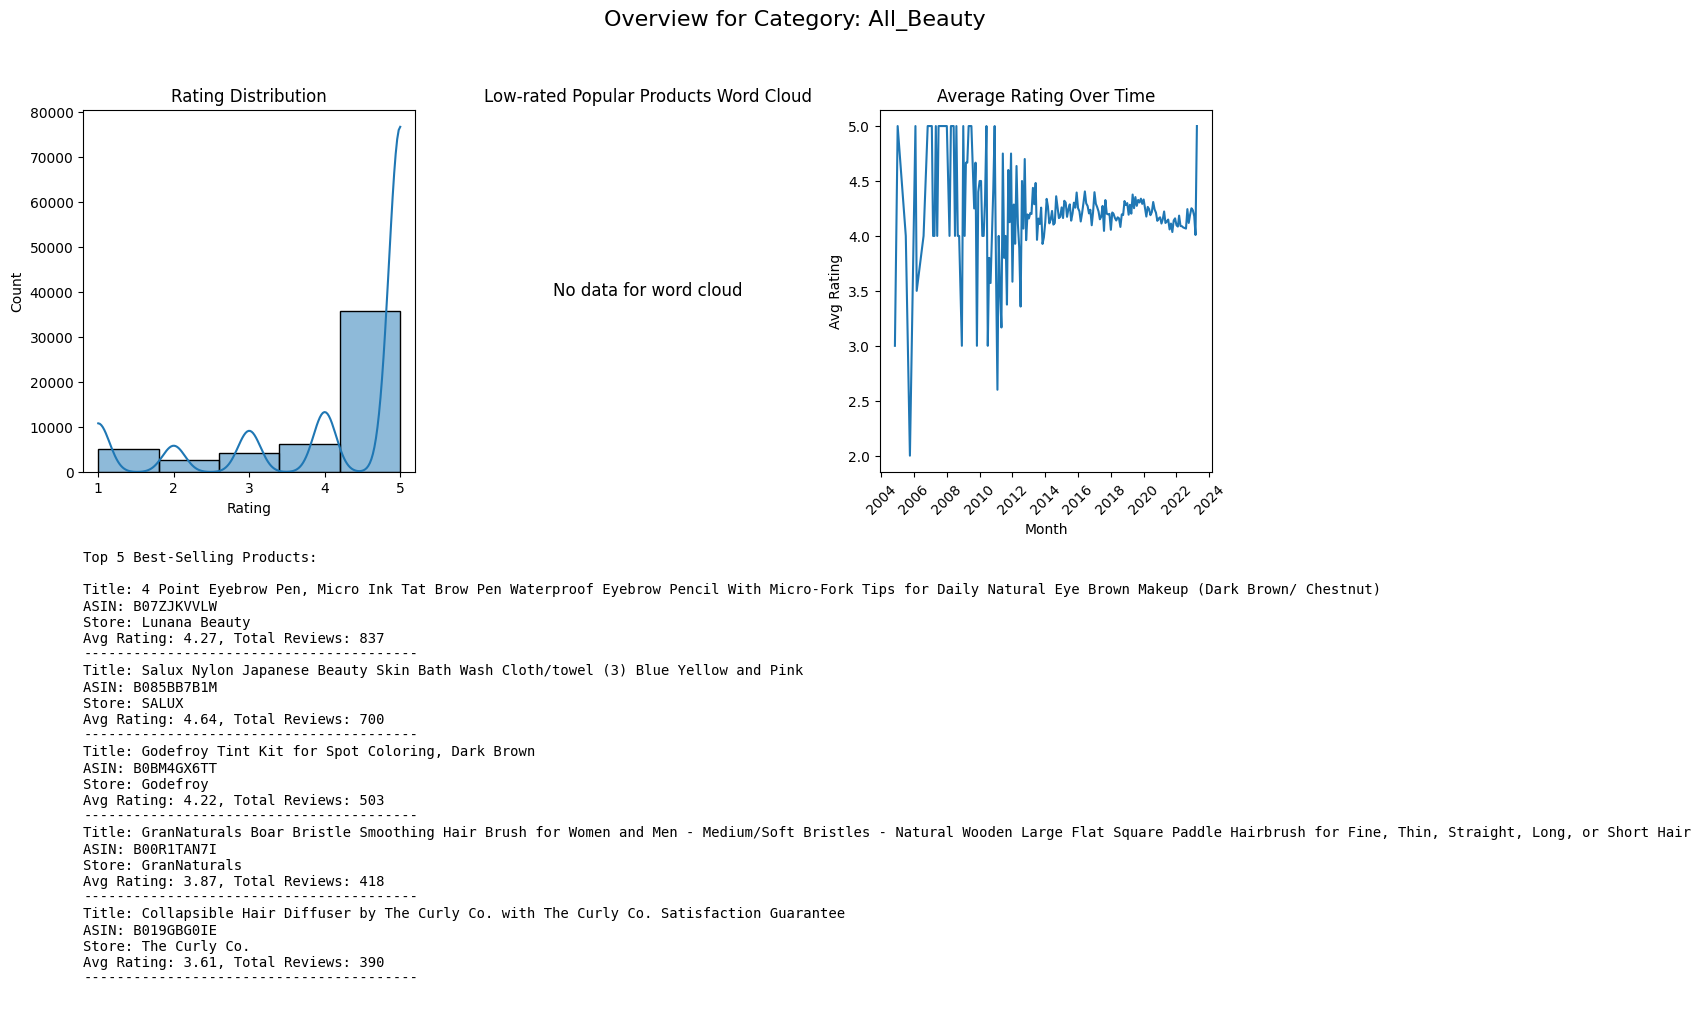

Visualizing: Electronics


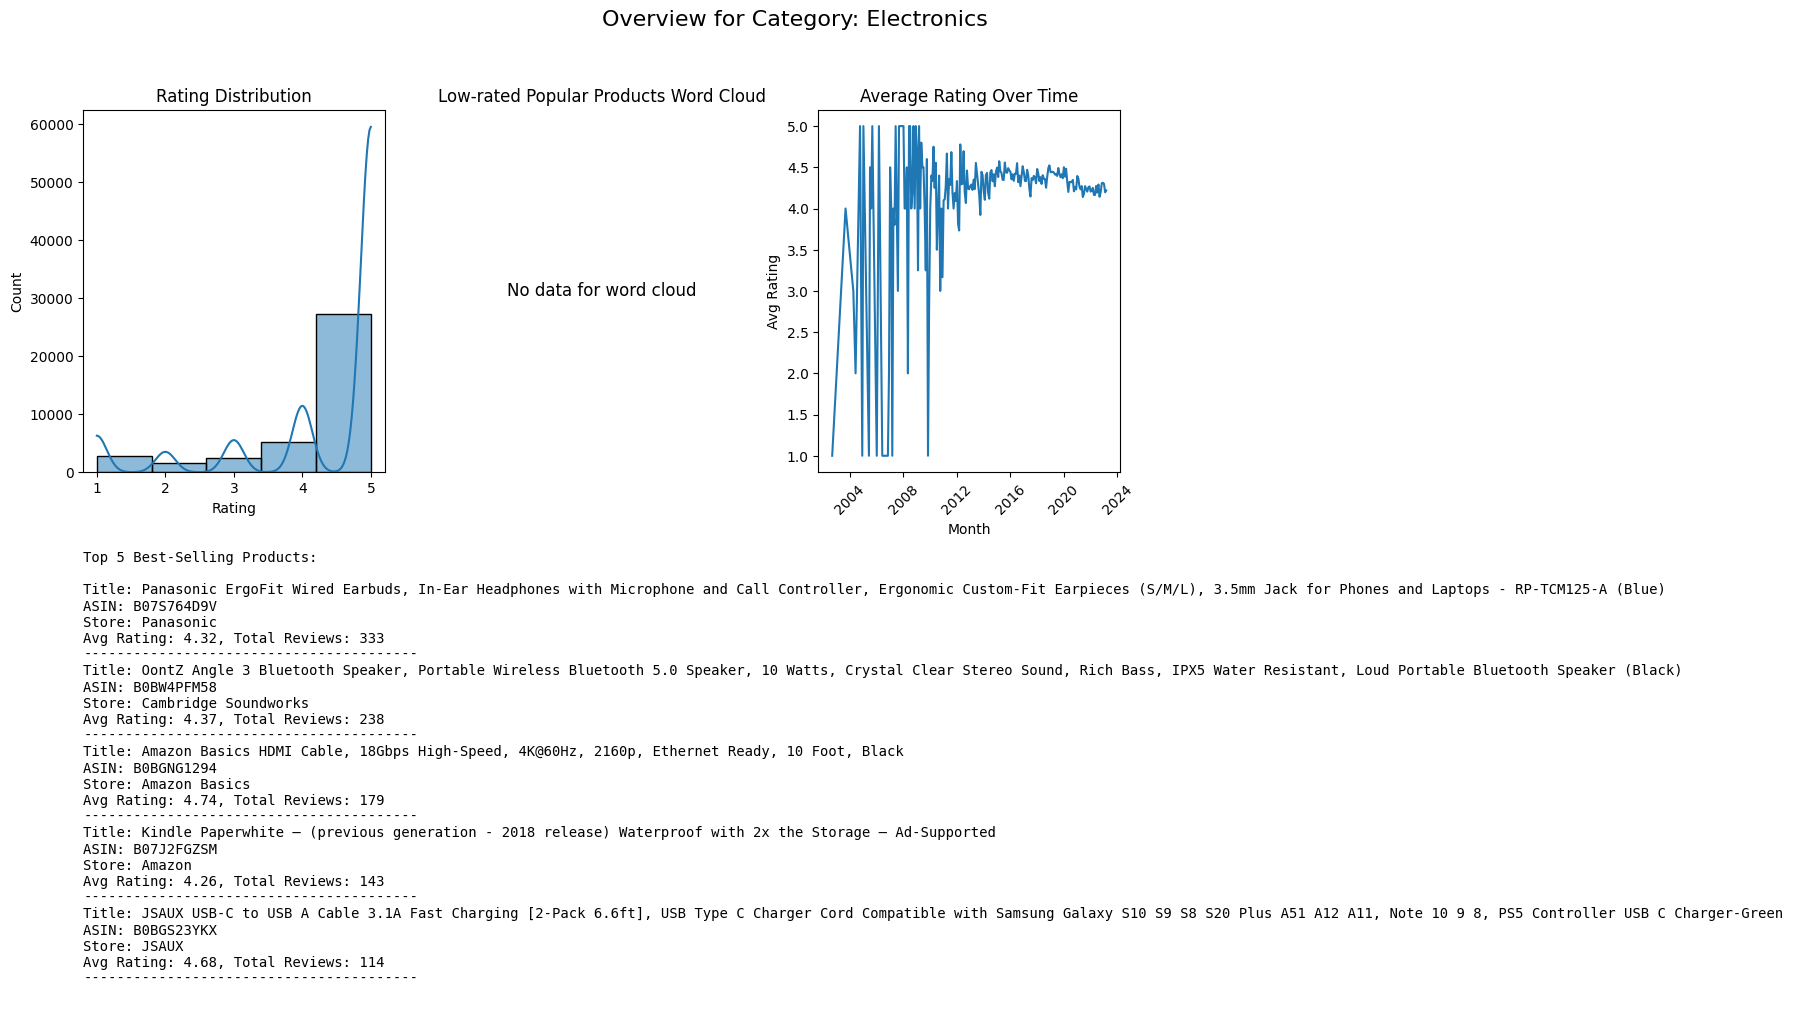

Visualizing: Movies_and_TV


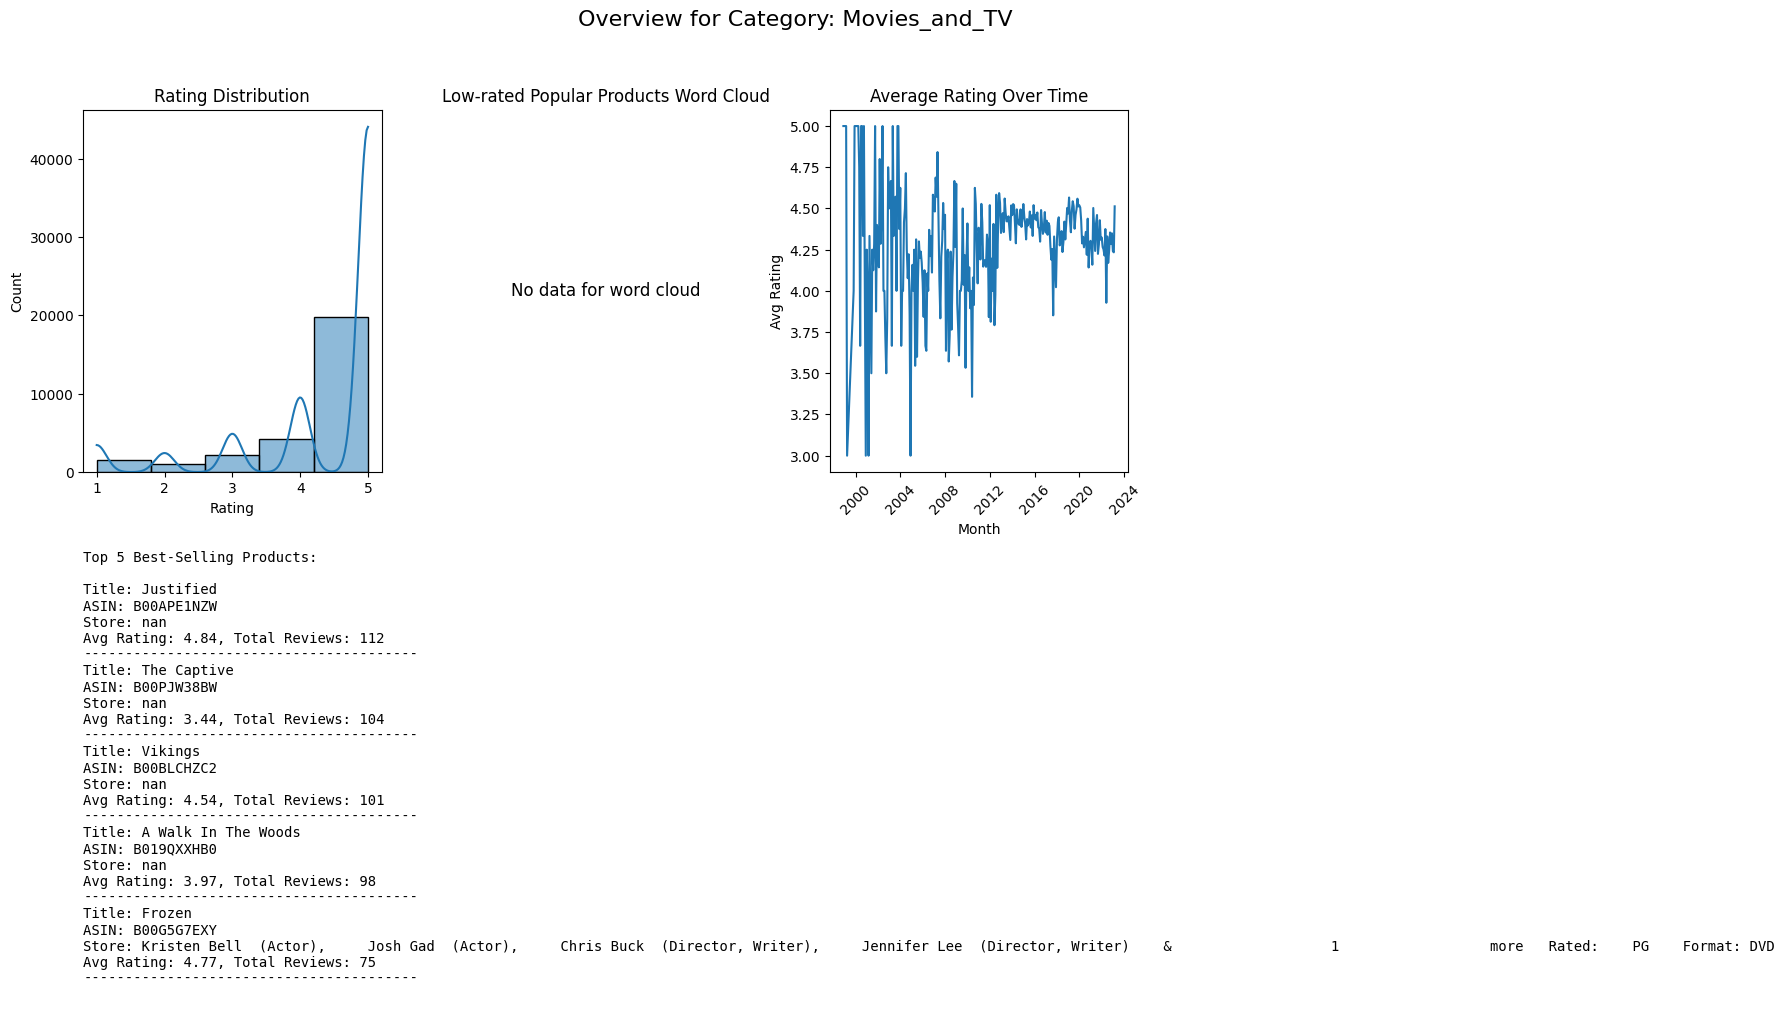

Visualizing: Sports_and_Outdoors


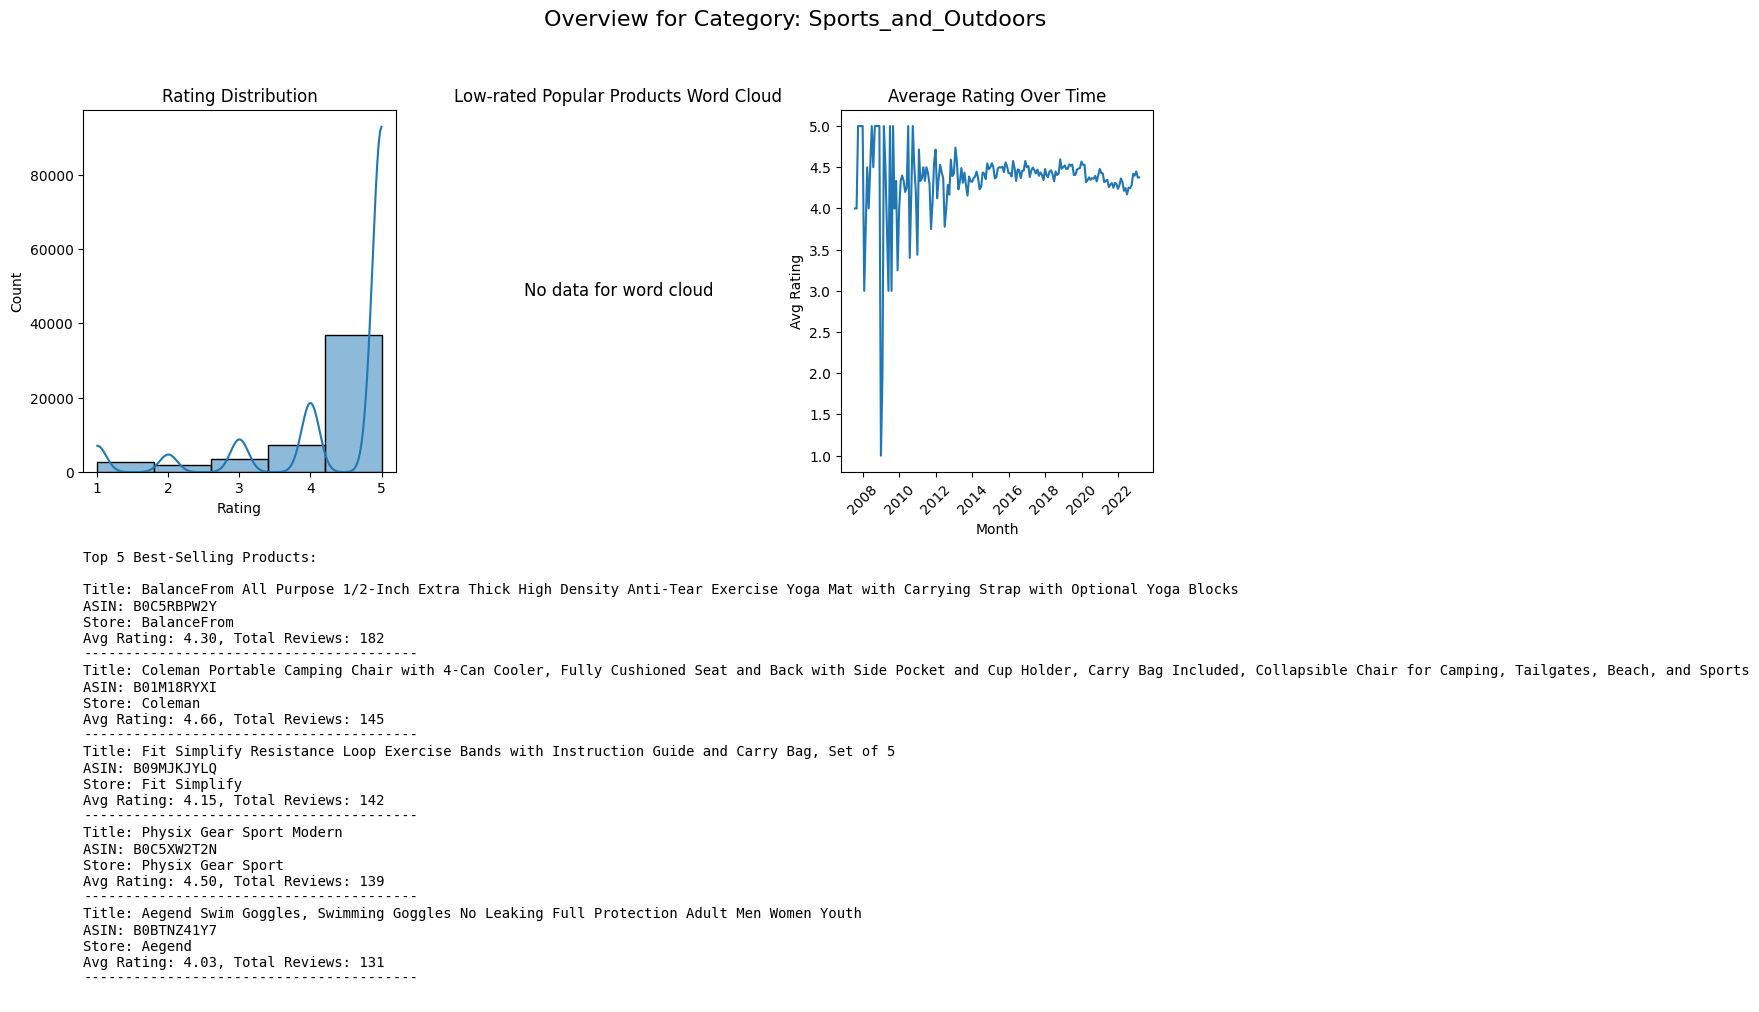

In [45]:
for category, *_ in datasets_info:
    print(f"Visualizing: {category}")
    df = pd.read_csv(f"{category}_cleaned.csv")
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["month"] = df["timestamp"].dt.to_period("M").dt.to_timestamp()

    # Prepare word cloud data
    stats = df.groupby("parent_asin").agg(avg_rating=("rating", "mean"), count=("rating", "count")).reset_index()
    bad_asins = stats[(stats["count"] > 50) & (stats["avg_rating"] < 3.0)]["parent_asin"]
    bad_text = " ".join(df[df["parent_asin"].isin(bad_asins)]["cleaned_text"].dropna())
    wordcloud = None
    if bad_text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(bad_text)

    # Prepare trend data
    trend = df.groupby("month")["rating"].mean().reset_index()

    # Prepare top products text
    top5 = df["parent_asin"].value_counts().head(5).index
    top_products_info = ""
    for asin in top5:
        item = df[df["parent_asin"] == asin].iloc[0]
        avg_rating = df[df["parent_asin"] == asin]["rating"].mean()
        total_reviews = len(df[df["parent_asin"] == asin])
        top_products_info += (
            f"Title: {item.get('title_meta', 'N/A')}\n"
            f"ASIN: {asin}\n"
            f"Store: {item.get('store', 'Unknown')}\n"
            f"Avg Rating: {avg_rating:.2f}, Total Reviews: {total_reviews}\n"
            f"{'-'*40}\n"
        )

    # Create subplots
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle(f"Overview for Category: {category}", fontsize=16, y=1.02)
    gs = GridSpec(2, 3, figure=fig)

    # Histogram
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(df["rating"], bins=5, kde=True, ax=ax1)
    ax1.set_title("Rating Distribution")
    ax1.set_xlabel("Rating")
    ax1.set_ylabel("Count")

    # Word Cloud
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title("Low-rated Popular Products Word Cloud")
    if wordcloud:
        ax2.imshow(wordcloud, interpolation="bilinear")
        ax2.axis("off")
    else:
        ax2.text(0.5, 0.5, "No data for word cloud", ha='center', va='center', fontsize=12)
        ax2.axis("off")

    # Trend Line
    ax3 = fig.add_subplot(gs[0, 2])
    sns.lineplot(data=trend, x="month", y="rating", ax=ax3)
    ax3.set_title("Average Rating Over Time")
    ax3.set_xlabel("Month")
    ax3.set_ylabel("Avg Rating")
    ax3.tick_params(axis='x', rotation=45)

    # Text Box for Top Products
    ax4 = fig.add_subplot(gs[1, :])
    ax4.axis("off")
    ax4.text(0, 1, f"Top 5 Best-Selling Products:\n\n{top_products_info}", ha='left', va='top', fontsize=10, family='monospace')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


Ιδεα αυτοματοποιησης
```python
class Sentiment_Score_and_Ratig
    sentiment extractor = {
        Vader
        DistilBERT
        RoBERTa
        BERT
    }

    sentiment_score_weighted_text_rating(w0, w1, sentiment_exctractor )


    sentiment_score_rating_adjusted
```

### Task 2: Feature Engineering with **Sentiment Scores** and Ratings

#### Alternative 1: Weighted Combination of Text Sentiment and Rating  

In [46]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
import numpy as np

class SentimentScoreWithRating:
    def __init__(self, method="vader"):
        """
        method: "vader" or one of ["distilbert", "roberta", "bert"]
        """
        self.method = method.lower()
        if self.method == "vader":
            self.analyzer = SentimentIntensityAnalyzer()
        elif self.method in ["distilbert", "roberta", "bert"]:
            model_map = {
                "distilbert": "distilbert-base-uncased-finetuned-sst-2-english",
                "roberta": "cardiffnlp/twitter-roberta-base-sentiment",
                "bert": "nlptown/bert-base-multilingual-uncased-sentiment"
            }
            self.analyzer = pipeline("sentiment-analysis", model=model_map[self.method])
        else:
            raise ValueError("Unsupported method")

    def extract_sentiment_score(self, text):
        """
        Returns a sentiment score in range [-1, +1]
        """
        if self.method == "vader":
            score = self.analyzer.polarity_scores(text)["compound"]
            return score
        else:
            result = self.analyzer(text[:256])[0]  # Truncate long reviews
            label = result["label"].lower()
            if "positive" in label:
                return 1.0
            elif "negative" in label:
                return -1.0
            else:
                return 0.0

    def normalize_rating(self, rating):
        """
        Normalize rating from 1–5 stars to 0–1
        """
        return (rating - 1) / 4

    def sentiment_score_weighted_text_rating(self, text, rating, w_text=0.5, w_rating=0.5):
        """
        Returns the weighted combination score
        """
        sentiment = self.extract_sentiment_score(text)
        norm_rating = self.normalize_rating(rating)
        combined_score = w_text * sentiment + w_rating * norm_rating
        return combined_score

### Task 3: Feature Engineering with Price Metrics (Optional)

## Part 2 - Learning Tasks